# Parrot Sequoia Image Processing Tutorial

## Overview

Micasense has made an open python library with image processing tools and tutorials for their RedEdge sensor. These tools are also higly relevant for processing Parrot Sequoia images. I have added some functionality to the micasense library, which enables processing of Sequoia imagery. 

This tutorial is similar to the `MicaSense RedEdge Image Processing Tutorial 1`. It walks through how to convert Sequoia data from raw images to irradiance normalised with data from the sunshine sensor and then to reflectance. Vignette correction and removal of fish-eye distortion is also part of the workflow.

The code is found in the file `sequoiautils.py`. Most of the code has originally been shared by other users in the [Parrot developer forum](https://forum.developer.parrot.com/c/sequoia) (see details in the relevant sections below and in the script).

This tutorial assumes you have gone through the basic setup [here](./MicaSense Image Processing Setup.html) and your system is set up and ready to go.


### Opening an image with pyplot

Sequoia 16-bit images can be read with pyplot directly into numpy arrays using the pyplot `imread` function or the matplotlib `imread` function, and then we can display the image inline using the `imshow` function of `matplotlib`.


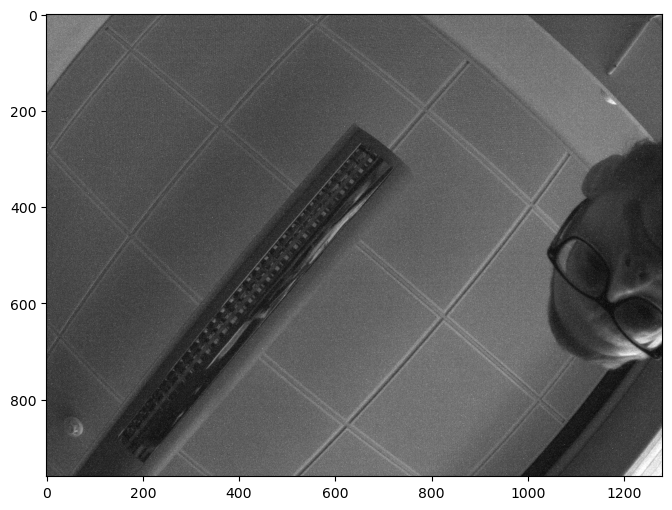

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os,glob
import math
%matplotlib inline

imagePath = os.path.join('.','data','Sequoia','0077')
imageName = '/Users/thomasn/Library/CloudStorage/OneDrive-EdgeHillUniversity/Research/Drone/sequoia/IMG_700101_000252_0006_NIR.TIF'

# Read raw image DN values
# reads 16 bit tif - this will likely not work for 12 bit images
imageRaw=plt.imread(imageName)

# Display the image
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(imageRaw, cmap='gray')
plt.show()

### Adding a colorbar

We will use start by using a plotting function in `micasense.plotutils` that adds a colorbar to the display, so that we can more easily see changes in the values in the images and also see the range of the image values after various conversions.  This function also colorizes the grayscale images, so that changes can more easily be seen.  Depending on your viewing style, you may prefer a different color map and you can also select that colormap here or browsing the colormaps on the [matplotlib site](https://matplotlib.org/users/colormaps.html). 

<Figure size 640x480 with 0 Axes>

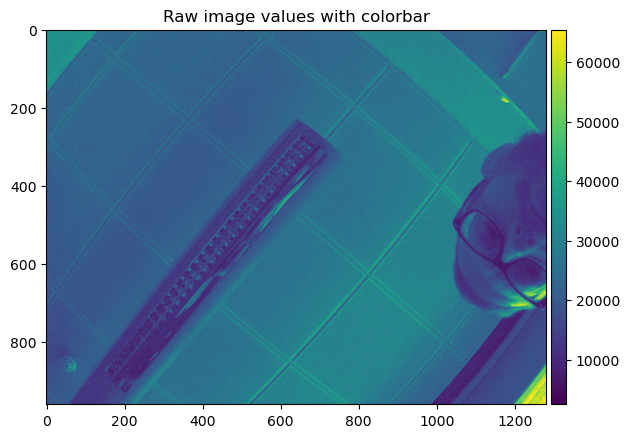

In [2]:
import micasense.plotutils as plotutils

# Optional: pick a color map that fits your viewing style
# one of 'gray, viridis, plasma, inferno, magma, nipy_spectral'
plotutils.colormap('viridis')

plotutils.plotwithcolorbar(imageRaw, title='Raw image values with colorbar');

### Reading Sequoia Metadata

In order to perform various processing on the images, we need to read the metadata of each image.  For this we use ExifTool. We can read standard image capture metadata such as location, UTC time, imager exposure and gain, but also Sequoia specific metadata which can make processing workflows easier.


In [6]:
import micasense.metadata as metadata
import exiftool
# get image metadata

with exiftool.ExifToolHelper() as et:
    metadata = et.get_metadata(imageName)[0]

    print(metadata)
    
    #meta = metadata.Metadata(imageName)
    camera_make = metadata['EXIF:Make']
    
    camera_model = metadata['EXIF:Model']
    firmware_version = metadata['EXIF:Software']
    band_name = metadata['XMP:BandName']

    expo_time = metadata['EXIF:ExposureTime']

    image_gain = metadata['EXIF:ISO']

    img_width, img_height = metadata['EXIF:ImageWidth'], metadata['EXIF:ImageHeight']

    center_wavelength = metadata['XMP:CentralWavelength']

    bandwidth = metadata['XMP:WavelengthFWHM']

    focal_length = metadata['EXIF:FocalLength']
    
    print(f"firmware version: {metadata['EXIF:Make']}, {metadata['EXIF:Model']}, {metadata['EXIF:Software']}")
    
    print(f"Exposure Time: {expo_time}")
    print(f"image gain: {image_gain/100}") # Need to divide by 100
    print(f'Size (w, h): {img_width, img_height}')
    print(f'Band Name: {band_name}')
    print(f'Center Wavelength: {center_wavelength} nm')
    print(f'Bandwidth: {bandwidth} nm')
    print(f'Focal Length: {focal_length}')

    

{'SourceFile': '/Users/thomasn/Library/CloudStorage/OneDrive-EdgeHillUniversity/Research/Drone/sequoia/IMG_700101_000252_0006_NIR.TIF', 'ExifTool:ExifToolVersion': 12.76, 'File:FileName': 'IMG_700101_000252_0006_NIR.TIF', 'File:Directory': '/Users/thomasn/Library/CloudStorage/OneDrive-EdgeHillUniversity/Research/Drone/sequoia', 'File:FileSize': 2462962, 'File:FileModifyDate': '2025:05:29 16:50:57+01:00', 'File:FileAccessDate': '2025:05:29 18:14:41+01:00', 'File:FileInodeChangeDate': '2025:05:29 16:51:36+01:00', 'File:FilePermissions': 100700, 'File:FileType': 'TIFF', 'File:FileTypeExtension': 'TIF', 'File:MIMEType': 'image/tiff', 'File:ExifByteOrder': 'II', 'EXIF:ImageWidth': 1280, 'EXIF:ImageHeight': 960, 'EXIF:BitsPerSample': 16, 'EXIF:Compression': 1, 'EXIF:PhotometricInterpretation': 1, 'EXIF:ImageDescription': '790 nm', 'EXIF:Make': 'Parrot', 'EXIF:Model': 'Sequoia', 'EXIF:StripOffsets': 8, 'EXIF:Orientation': 3, 'EXIF:SamplesPerPixel': 1, 'EXIF:StripByteCounts': 2457600, 'EXIF:Mi

### Converting raw Sequoia images to irradiance

This step includes vignette correction and conversion of raw image to irradiance using the sensor calibration model.

First a vignette map is created following the procedure described in the [Application note: How to correct vignetting in images](https://forum.developer.parrot.com/uploads/default/original/2X/b/b9b5e49bc21baf8778659d8ed75feb4b2db5c45a.pdf). The implemented code is written by 
[seanmcleod](https://forum.developer.parrot.com/t/vignetting-correction-sample-code/5614). The vignette map will be multiplied by the raw image values to reverse the darkening seen at the image corners.  See the `vignette_correction` function for the details of the vignette parameters and their use.
```python
    V = vignette_correction(meta, xDim, yDim)
```

The conversion of raw image to irradiance is done following the procedure described in the [Application note: Pixel value to irradiance using the sensor calibration model](https://forum.developer.parrot.com/uploads/default/original/2X/3/383261d35e33f1f375ee49e9c7a9b10071d2bf9d.pdf). The procedure is described in more details in this [document](https://onedrive.live.com/?authkey=%21ACzNLk1ORe37aRQ&cid=C34147D823D8DFEF&id=C34147D823D8DFEF%2115414&parId=C34147D823D8DFEF%21106&o=OneUp).


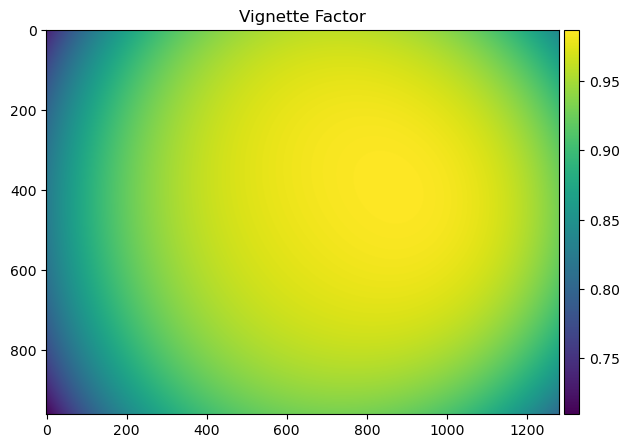

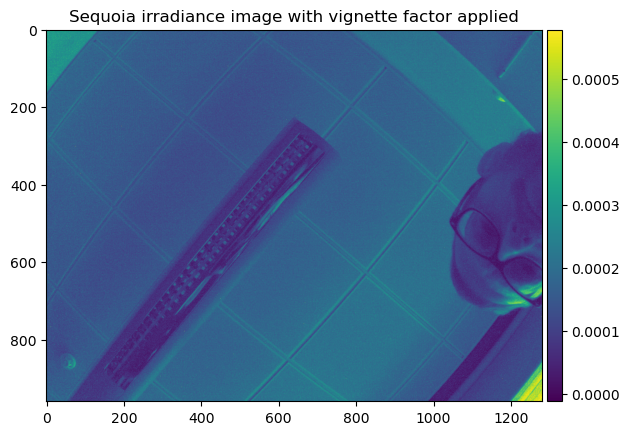

In [4]:
import micasense.sequoiautils as msutils
SequoiaIrradiance, V = msutils.sequoia_irradiance(metadata, imageRaw)
plotutils.plotwithcolorbar(V,'Vignette Factor');
plotutils.plotwithcolorbar(SequoiaIrradiance,'Sequoia irradiance image with vignette factor applied');

### Sunshine calibration of Sequoia irradiance image
Next step is to calculate the sunshine irradiance. This is used to normalise the images in an image dataset according to variations in the incomming solar radiation. The implemented code for retrieving the sunshine sensor data is written by [Yu-Hsuan Tu](https://github.com/dobedobedo/Parrot_Sequoia_Image_Handler/tree/master/Modules/Dependency).

In [5]:
# Sunshine sensor Irradiance
SunIrradiance = msutils.GetSunIrradiance(metadata)
print ('Sunshine sensor irradiance: ', SunIrradiance)

# Light calibrated sequoia irradiance
SequoiaIrradianceCalibrated = SequoiaIrradiance/SunIrradiance
plotutils.plotwithcolorbar(SequoiaIrradianceCalibrated,'Light calibrated Sequoia irradiance image');

KeyError: 'XMP:IrradianceList'

### Convert irradiance to reflectance

The calibrated iradiance image can now be converted into reflectance. To do this, an image of a reflectance panel with known reflectance is required. The irradiance values of the panel image is then used to determine a scale factor between irradiance and reflectance.

For now I do not have a Sequoia example. But the procedure is similar to the RedEdge procedure described in the `MicaSense RedEdge Image Processing Tutorial 1`.

### Undistorting images

Finally, lens distortion effects can be removed from the images using the information in the [Application note: How to correct distortion in images](https://forum.developer.parrot.com/uploads/default/original/2X/e/ec302e9e4498cba5165711c2a52fa2c37be10431.pdf). The implemented code is originally written in Matlab by [muzammil360](https://github.com/muzammil360/SeqUDR) and has been modified and rewritten in Python.

Generally for photogrammetry processes on raw (or irradiance/reflectance) images, this step is not required, as the photogrammetry process will optimize a lens distortion model as part of it's bulk bundle adjustment.

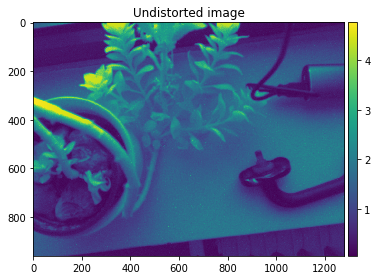

In [35]:
# correct for lens distortions to make straight lines straight
undistortedImage = msutils.correct_lens_distortion_sequoia(meta, SequoiaIrradianceCalibrated)
plotutils.plotwithcolorbar(undistortedImage, 'Undistorted image');

---
Copyright (c) 2017-2018 MicaSense, Inc.  For licensing information see the [project git repository](https://github.com/micasense/imageprocessing)